This script finds out the contact probabilities between residues of two interacting protein and generates a contact frequency heatmap. In this example, the interactions between the cytosolic domains of two proteins are studied.

In [1]:
# Load the required modules
import MDAnalysis as mda
import numpy as np
from tqdm import tqdm
import pandas as pd

In [ ]:
# Load the structure file and trajectory and create the MDAnalysis Universe

PSF = 'protein.psf' # Assuming the structure file is in the current directory
XTCs = [
    'run1_centered.xtc',
    'run2_centered.xtc',
] # Loading two replicate runs, centered and autoimaged using CPPTRAJ


In [ ]:
# First, generate an m x n array, where m and n are the number of residues of interest in protein A and protein B

contact_counts = np.zeros((78, 31), dtype=int)
total_frames = 0
start = 500 # If you want to skip the first 500 frames from analysis
stop = 5000 
step = 1

In [ ]:
for XTC in XTCs:
    u = mda.Universe(PSF, XTC)
    u_prot = u.select_atoms('segid PRO* and not name H*', updating=True) # Assuming both the protein segments are named PRO*
    prot_B_CD = u.select_atoms('segid PROB and resid 260 to 290 and not name H*') # protein B has cytosolic domain stretching from 260 to 290
    prot_A_CD = u.select_atoms('segid PROA and (resid 1:49 or resid 155:183) and not name H*') # protein A has two cytosolic domains 1-49 and 155-183

    # Find the residues in protein A contacting residues in protein B
    contacts_per_resid = {
        resid: u_prot.select_atoms(f'segid PROA and around 3.5 (resid {resid})', 
                                   updating=True)
        for resid in prot_B_CD.residues.resids
    }

    for ts in tqdm(u.trajectory[start:stop:step]):
        for prot_B_idx, (prot_B_resid, contacts) in enumerate(contacts_per_resid.items()):
            contact_resids = contacts.residues.resids
            for prot_A_idx, prot_A_resid in enumerate(prot_A_CD.residues.resids):
                if prot_A_resid in contact_resids:
                    contact_counts[prot_A_idx, prot_B_idx] += 1

        total_frames+=1


In [ ]:
# Calculate the contact frequencies from contact counts

contact_freq = contact_counts/total_frames
contact_freq_df = pd.DataFrame(contact_freq, index=prot_A_CD.residues.resids, columns=prot_B_CD.residues.resids)
contact_freq_df

In [ ]:
# Relabel the residues 

residue_symbols = {
    'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C',
    'GLN': 'Q', 'GLU': 'E', 'GLY': 'G', 'HSD': 'H', 'ILE': 'I',
    'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P',
    'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V'
}

prot_B_CD_residues_labels = [f'{res.resname}{res.resid}' for res in prot_B_CD.residues]
prot_A_CD_residues_labels = [f'{res.resname}{res.resid}' for res in prot_A_CD.residues]

contact_freq_df.index = prot_A_CD_residues_labels
contact_freq_df.columns = prot_B_CD_residues_labels

contact_freq_df

In [ ]:
# Save the data
contact_freq_df.to_csv('contact_freq_run1,2_averaged_500ns.csv', header=True, index=True)

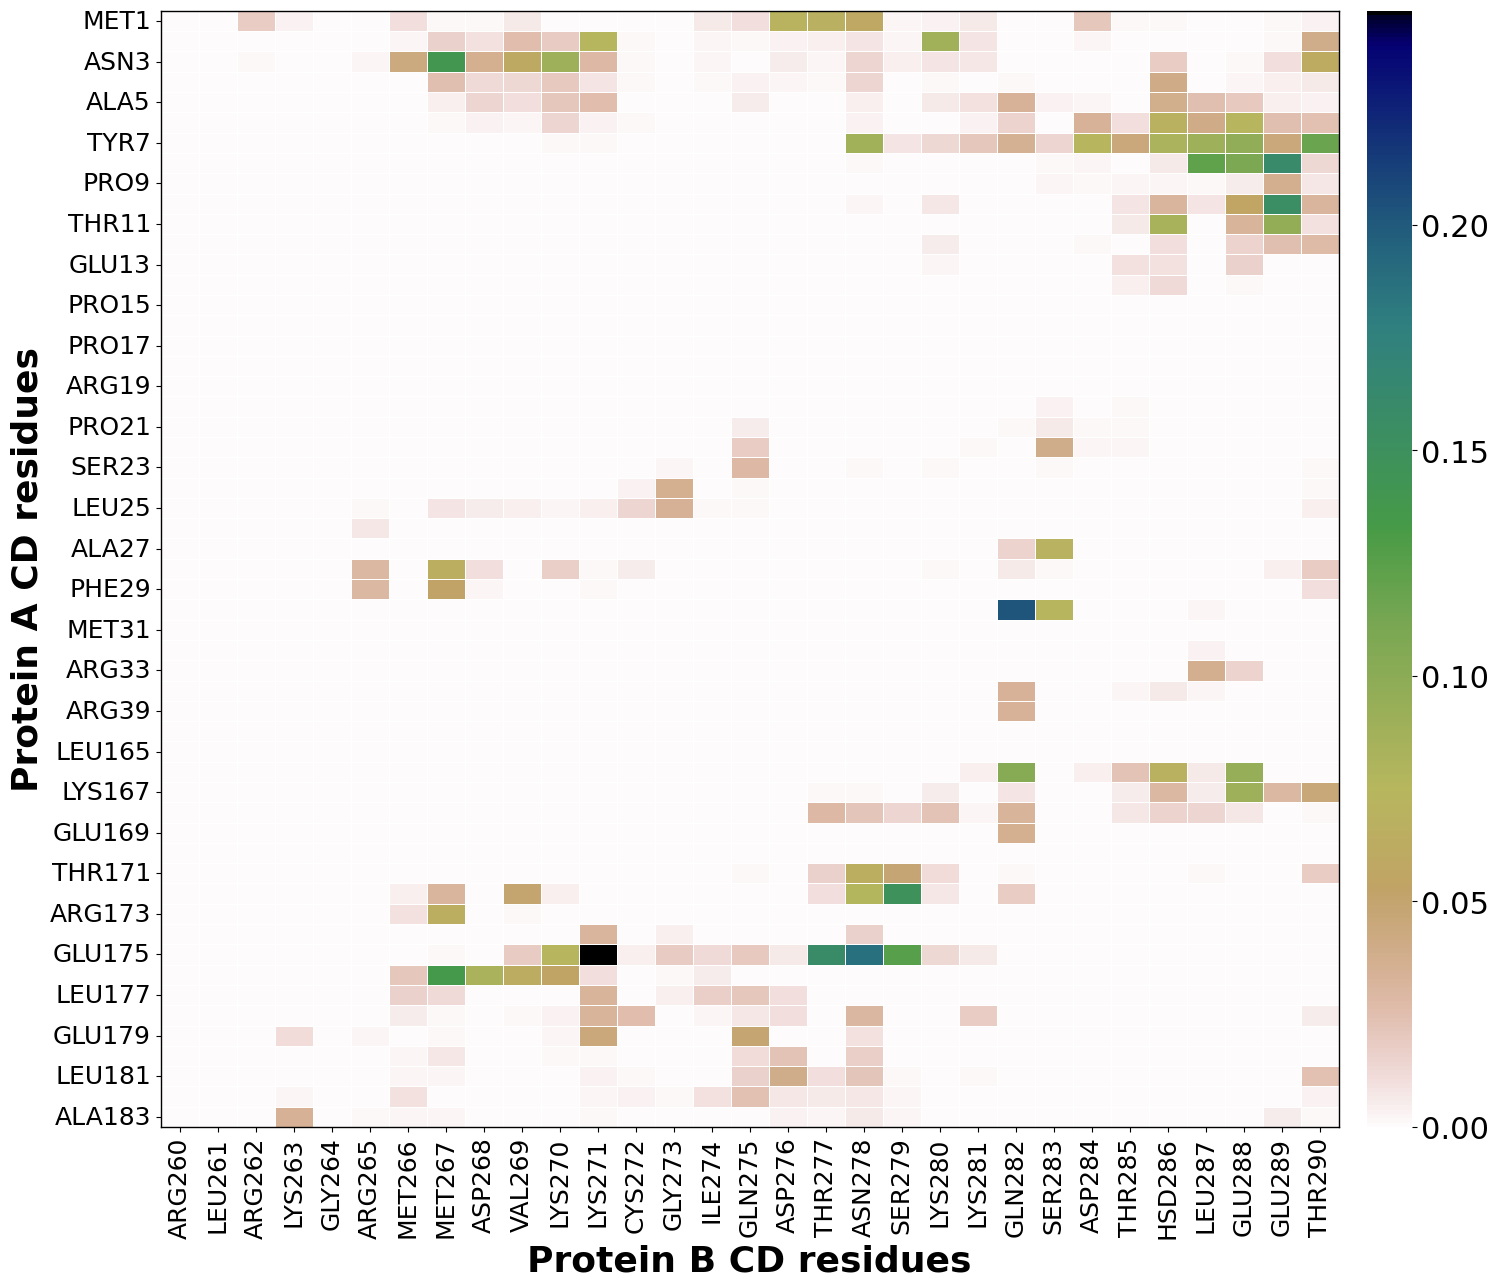

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
contact_freq = pd.read_csv('contact_freq_run1,2_averaged_500ns.csv', index_col=0)
# Optionally, select specific residues to plot by filtering the dataframe. In this example, we select residues 1-34, 38-39, and the last 20 residues
contact_freq_trimmed = pd.concat([contact_freq.iloc[:34], contact_freq.iloc[38:39], contact_freq.iloc[-20:]])

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(16, 13)) 
sns.heatmap(
    contact_freq_trimmed,
    cmap='gist_earth_r', 
    cbar=True, 
    linewidth=0.6,
    linecolor='white',
    ax=ax,
    cbar_kws={'shrink': 1.0, 'aspect': 25, 'pad': 0.02}, # Customize the colorbar
    # vmin=0.0,
    # vmax=0.25
)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=22)

fontname = 'DejaVu Sans'
plt.xlabel("Protein B CD residues", fontsize=26, fontweight='bold', fontname=fontname)
plt.ylabel("Protein A CD residues", fontsize=26, fontweight='bold', fontname=fontname)
plt.xticks(fontsize=18, fontweight='normal', fontname=fontname)
# plt.yticks(fontsize=18, fontweight='normal', rotation=0, fontname=fontname)
plt.yticks(plt.gca().get_yticks()[::2], fontsize=18, fontweight='normal', rotation=0, fontname=fontname)

# Add a border around the entire plot
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

# Customize the border color and width
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')  # Set the color of the border
    spine.set_linewidth(1)        # Set the width of the border

plt.tight_layout()
# plt.savefig('contact_map_run1,2_averaged_trimmed.png', bbox_inches='tight', pad_inches=0.1, dpi=600)

plt.show()